In [1]:
import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import joblib
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple

from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

#Setting Up Parameters:
round_num = 5
num_clients = 5

model_name = "initial_model_datasample4.pkl"
test_data_name = "test_data_datasample4.pkl"

In [2]:
%%time

# Ensure all possible classes are included in each partial_fit call
all_classes = np.array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
                        'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 
                        'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator',
                        'Web Attack'])


# Set gRPC verbosity to debug (optional)
os.environ['GRPC_VERBOSITY'] = 'debug'

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (INFO, DEBUG, WARNING, etc.)
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Load the pre-trained model and test data
try:
#     initial_model = joblib.load('initial_model_FedProxi.pkl')
    initial_model = joblib.load(model_name)
    X_test, y_test = joblib.load(test_data_name)
    logging.info("Model and test data loaded.")
except FileNotFoundError:
    logging.error(f"Pre-trained model or test data not found. Please ensure {initial_model_name} and {test_data_name} exist.")
    raise

# Function to extract model parameters
def get_model_parameters(model):
    return [param for param in model.coefs_] + [param for param in model.intercepts_]

# Function to set model parameters
def set_model_parameters(model, parameters):
    num_layers = len(model.coefs_)
    model.coefs_ = parameters[:num_layers]
    model.intercepts_ = parameters[num_layers:]

# Lists to store Client side metrics
client_side_losses = []
client_side_accuracies = []
learning_rates = []

server_side_losses = []
server_side_accuracies = []
server_side_precision_avr = []
server_side_precision_macro = []

# Define the evaluation function
def evaluate(server_round, parameters, config):
    if isinstance(parameters, fl.common.Parameters):
        parameters_ndarrays = parameters_to_ndarrays(parameters)
    else:
        parameters_ndarrays = parameters

    set_model_parameters(initial_model, parameters_ndarrays)
    server_side_losses = initial_model.loss_
    server_side_accuracies = initial_model.score(X_test, y_test)
    y_pred = initial_model.predict(X_test)
    server_side_precision_avr = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    server_side_precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    
    logging.info(f"Server Evaluation - Round {server_round}: Servers Loss = {server_side_losses }")
    logging.info(f"Server Evaluation - Round {server_round}: Servers Accuracy = {server_side_accuracies * 100:.2f}%")
    logging.info(f"Server Evaluation - Round {server_round}: Servers Precision Weighted = {server_side_precision_avr * 100:.2f}%")
    logging.info(f"Server Evaluation - Round {server_round}: Servers Precision Macro = {server_side_precision_macro * 100:.2f}%")
    return server_side_losses , {"accuracy": server_side_accuracies,
                                 "precision_avg":server_side_precision_avr,
                                 "precision_macro": server_side_precision_macro}

# Custom function to aggregate evaluation results
def weighted_average(results):
    accuracies = [r.metrics["accuracy"] * r.num_examples for _, r in results]
    examples = [r.num_examples for _, r in results]
    aggregated_accuracy = sum(accuracies) / sum(examples)
    
    # Assuming all clients return loss
    losses = [r.metrics["loss"] * r.num_examples for _, r in results]
    aggregated_loss = sum(losses) / sum(examples)
    
    return aggregated_loss, {"accuracy": aggregated_accuracy}

# Adaptive learning rate function decrease lr after 3 rounds with no improvement
def adaptive_learning_rate(round_number, initial_lr=0.00001, decay_factor=0.9, patience=3):
    if len(client_side_losses) > patience:
        recent_losses = client_side_losses[-patience:]
        if recent_losses[-1] >= min(recent_losses):
            return initial_lr * decay_factor
    return initial_lr

# create custom strategy class
class FedAvgWithCustomAggregation(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self, 
        server_round: int, 
        results: list, 
        failures: list
    ) -> tuple:
        if not results:
            return None, {}
        
        # Use the custom weighted average function to aggregate results
        aggregated_loss, aggregated_metrics = weighted_average(results)
        logging.info(f"Round {server_round} aggregated loss: {aggregated_loss}, aggregated accuracy: {aggregated_metrics['accuracy'] * 100:.2f}%")
        
        # Apply the aggregated parameters to the initial model
        aggregated_parameters = super().aggregate_fit(server_round, results, failures)[0]
        set_model_parameters(initial_model, parameters_to_ndarrays(aggregated_parameters))       
 
        # Append the Client side metrics for further analysis
        client_side_losses.append(aggregated_loss)
        client_side_accuracies.append(aggregated_metrics["accuracy"])
        
        # Append the Server side metrics for further analysis
        server_side_losses.append(initial_model.loss_)
        server_side_accuracies.append(initial_model.score(X_test, y_test))   
        y_pred = initial_model.predict(X_test)
        server_side_precision_avr.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
        server_side_precision_macro.append(precision_score(y_test, y_pred, average='macro', zero_division=1))
        
        # Adjust the learning rate
        current_lr = adaptive_learning_rate(server_round)
        learning_rates.append(current_lr)
        logging.info(f"Round {server_round} adjusted learning rate: {current_lr}")

        return aggregated_parameters, aggregated_metrics

    
# Convert initial model parameters to Flower Parameters object
initial_parameters = ndarrays_to_parameters(get_model_parameters(initial_model))

# Define the strategy using the custom stated above
strategy = FedAvgWithCustomAggregation(
    fraction_fit=1.0,
    fraction_evaluate=0.0,
    min_fit_clients=num_clients,
    min_available_clients=num_clients, 
    initial_parameters=initial_parameters,
    evaluate_fn=evaluate,
)

# Start the Flower server with the custom strategy and timeout
logging.info("Starting the Flower server...")
fl.server.start_server(
    server_address="127.0.0.1:8882",
    config=fl.server.ServerConfig(num_rounds=round_num, round_timeout=6000),  # 2900 seconds timeout
    strategy=strategy,
)
logging.info("Server has shut down.")

2024-09-04 01:01:47,500 - INFO - Model and test data loaded.
2024-09-04 01:01:47,501 - INFO - Starting the Flower server...
INFO :      Starting Flower server, config: num_rounds=5, round_timeout=6000s
2024-09-04 01:01:47,502 - INFO - Starting Flower server, config: num_rounds=5, round_timeout=6000s
INFO :      Flower ECE: gRPC server running (5 rounds), SSL is disabled
2024-09-04 01:01:47,536 - INFO - Flower ECE: gRPC server running (5 rounds), SSL is disabled
INFO :      [INIT]
2024-09-04 01:01:47,537 - INFO - [INIT]
INFO :      Using initial global parameters provided by strategy
2024-09-04 01:01:47,538 - INFO - Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
2024-09-04 01:01:47,538 - INFO - Starting evaluation of initial global parameters
2024-09-04 01:01:48,432 - INFO - Server Evaluation - Round 0: Servers Loss = 0.06288021932338779
2024-09-04 01:01:48,433 - INFO - Server Evaluation - Round 0: Servers Accuracy = 97.

2024-09-04 01:02:26,913 - INFO - configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
2024-09-04 01:02:30,799 - INFO - aggregate_fit: received 5 results and 0 failures
2024-09-04 01:02:30,799 - INFO - Round 5 aggregated loss: 0.08696517691342845, aggregated accuracy: 96.78%
2024-09-04 01:02:31,654 - INFO - Round 5 adjusted learning rate: 9e-06
2024-09-04 01:02:32,522 - INFO - Server Evaluation - Round 5: Servers Loss = 0.06288021932338779
2024-09-04 01:02:32,523 - INFO - Server Evaluation - Round 5: Servers Accuracy = 85.76%
2024-09-04 01:02:32,523 - INFO - Server Evaluation - Round 5: Servers Precision Weighted = 92.53%
2024-09-04 01:02:32,524 - INFO - Server Evaluation - Round 5: Servers Precision Macro = 35.93%
INFO :      fit progress: (5, 0.06288021932338779, {'accuracy': 0.857610818933133, 'precision_avg': 0.9253011640408162, 'precision_macro': 0.3593057885496346}, 44.08887079998385)
2024-09-04 01:02:32,524 - INFO - fit

CPU times: total: 21.6 s
Wall time: 45.1 s


In [3]:
#Storing metrics
client_loss_5c_5e_5r = pd.DataFrame(client_side_losses, columns=["Loss"]) 
client_loss_5c_5e_5r.to_pickle("client_loss_5c_5e_5r_datasample4.pkl")

client_acc_5c_5e_5r = pd.DataFrame(client_side_accuracies, columns=["Accuracy"]) 
client_acc_5c_5e_5r.to_pickle("client_acc_5c_5e_5r_datasample4.pkl")

server_acc_5c_5e_5r = pd.DataFrame(server_side_accuracies, columns=["Accuracy"]) 
server_acc_5c_5e_5r.to_pickle("server_acc_5c_5e_5r_datasample4.pkl")

server_prec_5c_5e_5r = pd.DataFrame(server_side_precision_avr, columns=["Precision"]) 
server_prec_5c_5e_5r.to_pickle("server_prec_5c_5e_5r_datasample4.pkl")

server_prec_macro_5c_5e_5r = pd.DataFrame(server_side_precision_macro, columns=["Macro Precision"]) 
server_prec_macro_5c_5e_5r.to_pickle("server_prec_macro_5c_5e_5r_datasample4.pkl")

In [4]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Client Side Accuracies and Server Side Accuracies
axs[0].plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o', label='Client Side Accuracy')
axs[0].plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='x', label='Server Side Accuracy')
axs[0].set_title('Accuracy Over Rounds')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='best')

# Plot Server Side Macro Precision and Weighted Precision
axs[1].plot(range(1, len(server_side_precision_macro) + 1), server_side_precision_macro, marker='o', label='Server Side Macro Precision')
axs[1].plot(range(1, len(server_side_precision_avr) + 1), server_side_precision_avr, marker='x', label='Server Side Weighted Precision')
axs[1].set_title('Precision Over Rounds')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Precision')
axs[1].legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
# plt.savefig("Metrics_Comparison_FedAver.png", dpi=300, format="png")
plt.show()

In [5]:
# calculate predictions 
y_pred = initial_model.predict(X_test)
y_prob = initial_model.predict_proba(X_test)
loss_log = log_loss(y_test, y_prob)
# Print classification report
print(classification_report(y_test, y_pred))

# Calculating and printing accuracy, precision, recall, F1-score. Setting "zero_division=1" for those classes where non of the instances where predicted correclty
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate loss, and rocauc
loss = initial_model.loss_
loss_log = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# Storing initial model's metrics for later
general_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Precision_macro': precision_macro, 
    'Recall': recall,
    'F1-Score': f1,
    'Loss': loss,
    'Logistic Loss': loss_log,
    'ROC AUC': roc_auc
}

general_metrics_df = pd.DataFrame([general_metrics]).T
general_metrics_df.columns = ["Values"]
general_metrics_df.to_pickle("gen_met_5c_5r_5e_datasample4.pkl")
general_metrics_df

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

          BENIGN       0.96      0.88      0.92     82963
             Bot       0.00      0.00      0.00        77
            DDoS       0.43      0.87      0.58      5069
   DoS GoldenEye       0.15      1.00      0.26       408
        DoS Hulk       0.98      0.82      0.89      6846
DoS Slowhttptest       0.13      0.89      0.23       207
   DoS slowloris       0.03      0.06      0.04       213
     FTP-Patator       0.00      0.00      0.00       235
      Heartbleed       0.00      0.00      0.00         1
    Infiltration       0.00      0.00      0.00         2
        PortScan       0.98      0.51      0.67      3591
     SSH-Patator       0.00      0.00      0.00       128
      Web Attack       0.01      0.05      0.01        85

        accuracy                           0.86     99825
       macro avg       0.28      0.39      0.28     99825
    weighted avg       0.93      0.86      0.88     99825



Values
Accuracy         0.857611
Precision        0.925291
Precision_macro  0.282383
Recall           0.857611
F1-Score         0.881208
Loss             0.062880
Logistic Loss    0.637147
ROC AUC          0.928190

In [6]:
# ###### import matplotlib.pyplot as plt

# # Create a figure with 1 row and 2 columns of subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Plot Client Side Accuracies in the first subplot
# axs[0].plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o')
# axs[0].set_title('Client Side Accuracies Over Rounds')
# axs[0].set_xlabel('Round')
# axs[0].set_ylabel('Accuracy')

# # Plot Server Side Accuracies in the second subplot
# axs[1].plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='o')
# axs[1].set_title('Server Side Accuracies Over Rounds')
# axs[1].set_xlabel('Round')
# axs[1].set_ylabel('Accuracy')

# # Adjust layout to prevent overlap
# plt.tight_layout()

# # Save the figure
# #plt.savefig("Accuracy_Comparison_FedAver_20.png", dpi=300, format ="png")

# # Show the plot
# plt.show()

In [7]:
# ###### import matplotlib.pyplot as plt

# # Create a figure with 1 row and 2 columns of subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Plot Client Side Accuracies in the first subplot
# axs[0].plot(range(1, len(server_side_precision_macro) + 1), server_side_precision_macro, marker='o')
# axs[0].set_title('Server Side Macro Precision Over Rounds')
# axs[0].set_xlabel('Round')
# axs[0].set_ylabel('Precision')

# # Plot Server Side Accuracies in the second subplot
# axs[1].plot(range(1, len(server_side_precision_avr) + 1), server_side_precision_avr, marker='o')
# axs[1].set_title('Server Side Weighted Precision Over Rounds')
# axs[1].set_xlabel('Round')
# axs[1].set_ylabel('Precision')

# # Adjust layout to prevent overlap
# plt.tight_layout()

# # Save the figure
# #plt.savefig("Accuracy_Comparison_FedAver_20.png", dpi=300, format ="png")

# # Show the plot
# plt.show()

In [8]:
#Storing metrics

# client_loss_10c_10e_5r = pd.DataFrame(client_side_losses, columns=["Loss"]) 
# #client_loss_10c_10e_5r.to_pickle("client_loss_10c_10e_5r.pkl")
# client_acc_10c_10e_5r = pd.DataFrame(client_side_accuracies, columns=["Loss"]) 
# #client_acc_10c_10e_5r.to_pickle("client_acc_10c_10e_5r.pkl")
# server_acc_10c_10e_5r = pd.DataFrame(server_side_accuracies, columns=["Accuracy"]) 
# #server_acc_10c_10e_5r.to_pickle("server_acc_10c_10e_5r.pkl")

In [9]:
learning_rates

[1e-05, 1e-05, 1e-05, 9e-06, 9e-06]

In [10]:
# Create a figure with 1 row and 2 columns of subplots
plt.figure(figsize=(12, 6))

# Client Side Accuracies Over Rounds
plt.subplot(1, 2, 1)
plt.plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o')
plt.title('Client Side Accuracies Over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')

# Client Side Losses Over Rounds
plt.subplot(1, 2, 2)
plt.plot(range(1, len(client_side_losses) + 1), client_side_losses, marker='o')
plt.title('Client Side Losses Over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')


plt.tight_layout()
plt.savefig("Client_side_metrics.png", dpi=300)
plt.show()

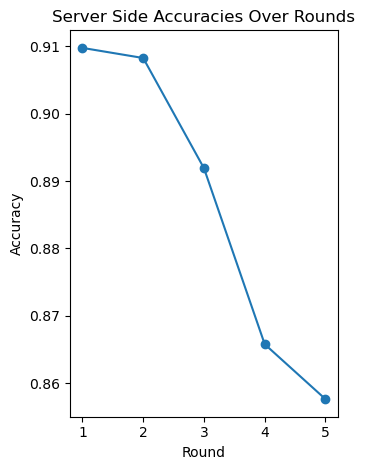

In [11]:
# Plot server side accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='o')
plt.title('Server Side Accuracies Over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig("Server_side.png", dpi=300)
plt.show()

##
## <code>Calculating metrics of :</code> 

**True Positive Rate (TPR)**: Also known as recall or sensitivity. $TPR = \frac{TP}{TP+FN}$
 
**False Positive Rate (FPR)**: $FPR = \frac{FP}{FP+TN}$

**True Negative Rate (TNR)** : $TNR = \frac {TN}{TN+FP}$

**False Negative Rate (FNR)** : $FNR = \frac {FN}{TP+FN}$

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Initialize lists to store TPR and FPR for each class
tpr_list = []
fpr_list = []

tp_list = []
fp_list = []
tn_list = []
fn_list = []

# Calculate TPR and FPR for each class
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    # Avoid division by zero
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    tpr_list.append(TPR)
    fpr_list.append(FPR)
    
    tp_list.append(TP)
    fp_list.append(FP)
    tn_list.append(TN)
    fn_list.append(FN)
    

# Convert lists to numpy arrays for easier manipulation if needed
tpr_array = np.array(tpr_list)
fpr_array = np.array(fpr_list)

tp_array = np.array(tp_list)
fp_array = np.array(fp_list)
tn_array = np.array(tn_list)
fn_array = np.array(fn_list)

# create attack classes metrics dataframe
attack_classes = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 
                  'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 
                  'PortScan', 'SSH-Patator', 'Web Attack']

eval_metrics = pd.DataFrame({
    'Attack Class': attack_classes,
    'True Positive Rate (TPR)': tpr_list,
    'False Positive Rate (FPR)': fpr_list,
    'True Positive (TP)': tp_list,
    'False Positives (FP)': fp_list,
    'True Negatives (TN)': tn_list,
    'False Negatives (FN)': fn_list
})

# Set 'Attack Class' as the index
eval_metrics.set_index('Attack Class', inplace=True)
eval_metrics.to_pickle("eval_met_5cars_5_epochs_5_rounds_datasample4.pkl") # Saving the evaluation metrics of initial model into separate files
eval_metrics

True Positive Rate (TPR)  False Positive Rate (FPR)  \
Attack Class                                                            
BENIGN                            0.881634                   0.167359   
Bot                               0.000000                   0.000411   
DDoS                              0.870783                   0.061094   
DoS GoldenEye                     1.000000                   0.023417   
DoS Hulk                          0.819311                   0.001506   
DoS Slowhttptest                  0.893720                   0.011905   
DoS slowloris                     0.061033                   0.004337   
FTP-Patator                       0.004255                   0.006215   
Heartbleed                        0.000000                   0.000000   
Infiltration                      0.000000                   0.000421   
PortScan                          0.510721                   0.000395   
SSH-Patator                       0.000000                   0.000221   
Web Attack                        0.047059                   0.007570   

                  True Positive (TP)  False Positives (FP)  \
Attack Class                                                 
BENIGN                         73143                  2822   
Bot                                0                    41   
DDoS                            4414                  5789   
DoS GoldenEye                    408                  2328   
DoS Hulk                        5609                   140   
DoS Slowhttptest                 185                  1186   
DoS slowloris                     13                   432   
FTP-Patator                        1                   619   
Heartbleed                         0                     0   
Infiltration                       0                    42   
PortScan                        1834                    38   
SSH-Patator                        0                    22   
Web Attack                         4                   755   

                  True Negatives (TN)  False Negatives (FN)  
Attack Class                                                 
BENIGN                          14040                  9820  
Bot                             99707                    77  
DDoS                            88967                   655  
DoS GoldenEye                   97089                     0  
DoS Hulk                        92839                  1237  
DoS Slowhttptest                98432                    22  
DoS slowloris                   99180                   200  
FTP-Patator                     98971                   234  
Heartbleed                      99824                     1  
Infiltration                    99781                     2  
PortScan                        96196                  1757  
SSH-Patator                     99675                   128  
Web Attack                      98985                    81

In [13]:
# Save the final model
joblib.dump(initial_model, 'final_model_5cars_5epoch_5rounds_datasample4.pkl')

['final_model_5cars_5epoch_5rounds_datasample4.pkl']